In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import astropy.cosmology.units as cu
from astropy.cosmology import Planck15 as cosmo
from Corrfunc.theory.DDrppi import DDrppi
from Corrfunc.theory.DD import DD
from Corrfunc.theory.wp import wp
from Corrfunc.theory.xi import xi
from Corrfunc.utils import convert_rp_pi_counts_to_wp
import os
import sys
sys.path.insert(0, '/work/08811/aew492/ls6/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfunc_ls
import tools

In [3]:
def perh():
    return (cosmo.H(0.) / 100 * u.Mpc / u.km * u.s) / cu.littleh

In [4]:
def get_dx(z, sigma_z):
    return sigma_z * (1 + z) * c.c.to(u.km/u.s) / cosmo.H(z) * perh()

In [5]:
def eval_Gaussian(loc, sigma, mean=0.):
    # pre = 1 / (sigma * np.sqrt(2 * np.pi))
    pre = 1 / sigma.unit if hasattr(sigma, 'unit') else 1
    exp = -(loc-mean)**2 / (2 * sigma**2)
    return pre * np.e**exp

In [6]:
def compute_wp_autocorr_LS(dset, rset, rp_edges, boxsize,
                     pimax=50, periodic=True, nthreads=12, dtype='float32'):
    # unpack positions
    xd, yd, zd = dset.T.astype(dtype)
    xr, yr, zr = rset.T.astype(dtype)
    # compute pair counts
    dd_res = DDrppi(1, nthreads, pimax, rp_edges, xd, yd, zd,
                      boxsize=boxsize, periodic=periodic, output_rpavg=True)
    dr_res = DDrppi(0, nthreads, pimax, rp_edges, xd, yd, zd, X2=xr, Y2=yr, Z2=zr,
                      boxsize=boxsize, periodic=periodic, output_rpavg=True)
    rr_res = DDrppi(1, nthreads, pimax, rp_edges, xr, yr, zr,
                      boxsize=boxsize, periodic=periodic, output_rpavg=True)
    dd = np.array([x['npairs'] for x in dd_res], dtype=dtype)
    dr = np.array([x['npairs'] for x in dr_res], dtype=dtype)
    rr = np.array([x['npairs'] for x in rr_res], dtype=dtype)
    return convert_rp_pi_counts_to_wp(len(dset), len(dset), len(rset), len(rset), dd, dr, dr, rr,
                                      len(rp_edges)-1, pimax)

In [9]:
def compute_xi_autocorr_natural(dset, rset, r_edges, boxsize, periodic=True, nthreads=12, dtype='float32'):
    # unpack positions
    xd, yd, zd = dset.T.astype(dtype)
    xr, yr, zr = rset.T.astype(dtype)
    # compute pair counts
    dd_res = DD(1, nthreads, r_edges, xd, yd, zd,
                      boxsize=boxsize, periodic=periodic, output_ravg=True)
    rr_res = DD(1, nthreads, r_edges, xr, yr, zr,
                      boxsize=boxsize, periodic=periodic, output_ravg=True)
    dd = np.array([x['npairs'] for x in dd_res], dtype=dtype)
    rr = np.array([x['npairs'] for x in rr_res], dtype=dtype)
    
    ndpairs = len(dset) * (len(dset)-1) / 2
    nrpairs = len(rset) * (len(rset)-1) / 2
    
    counts = np.divide(dd, rr, where=(rr!=0.), out=np.zeros_like(dd), dtype=dtype)
    
    return nrpairs / ndpairs * counts - 1, counts

In [10]:
def compute_wp_autocorr_natural(dset, rset, rp_edges, boxsize,
                     pimax=50, periodic=True, nthreads=12, dtype='float32', dpi=1.):
    # unpack positions
    xd, yd, zd = dset.T.astype(dtype)
    xr, yr, zr = rset.T.astype(dtype)
    # compute pair counts
    dd_res = DDrppi(1, nthreads, pimax, rp_edges, xd, yd, zd,
                      boxsize=boxsize, periodic=periodic, output_rpavg=True)
    rr_res = DDrppi(1, nthreads, pimax, rp_edges, xr, yr, zr,
                      boxsize=boxsize, periodic=periodic, output_rpavg=True)
    dd = np.array([x['npairs'] for x in dd_res], dtype=dtype)
    rr = np.array([x['npairs'] for x in rr_res], dtype=dtype)
    
    ndpairs = len(dset) * (len(dset)-1) / 2
    nrpairs = len(rset) * (len(rset)-1) / 2
    
    counts = np.divide(dd, rr, where=(rr!=0.), out=np.zeros_like(dd), dtype=dtype)
    
    xirppi = nrpairs / ndpairs * counts - 1
    
    wp = np.empty(len(rp_edges)-1)
    npibins = len(xirppi) // (len(rp_edges)-1)
    for i in range(nrpbins):
        wp[i] = 2.0 * dpi * np.sum(xirppi[i * npibins:(i + 1) * npibins])
        
    return wp, xirppi, dd, rr, dd_res

In [11]:
def compute_wp_xcorr_LS(d1set, d2set, r1set, r2set, rp_edges, boxsize,
                     pimax=50, periodic=True, nthreads=12, dtype='float32'):
    # unpack positions
    xd1, yd1, zd1 = d1set.T.astype(dtype)
    xd2, yd2, zd2 = d2set.T.astype(dtype)
    xr1, yr1, zr1 = r1set.T.astype(dtype)
    xr2, yr2, zr2 = r2set.T.astype(dtype)
    # compute pair counts
    d1d2_res = DDrppi(0, nthreads, pimax, rp_edges, xd1, yd1, zd1, X2=xd2, Y2=yd2, Z2=zd2,
                      boxsize=boxsize, periodic=periodic, output_rpavg=True)
    d1r2_res = DDrppi(0, nthreads, pimax, rp_edges, xd1, yd1, zd1, X2=xr2, Y2=yr2, Z2=zr2,
                      boxsize=boxsize, periodic=periodic, output_rpavg=True)
    d2r1_res = DDrppi(0, nthreads, pimax, rp_edges, xd2, yd2, zd2, X2=xr1, Y2=yr1, Z2=zr1,
                      boxsize=boxsize, periodic=periodic, output_rpavg=True)
    r1r2_res = DDrppi(0, nthreads, pimax, rp_edges, xr1, xr1, xr1, X2=xr2, Y2=yr2, Z2=zr2,
                      boxsize=boxsize, periodic=periodic, output_rpavg=True)
    d1d2 = np.array([x['npairs'] for x in d1d2_res], dtype=dtype)
    d1r2 = np.array([x['npairs'] for x in d1r2_res], dtype=dtype)
    d2r1 = np.array([x['npairs'] for x in d2r1_res], dtype=dtype)
    r1r2 = np.array([x['npairs'] for x in r1r2_res], dtype=dtype)
    return convert_rp_pi_counts_to_wp(len(d1set), len(d2set), len(r1set), len(r2set), d1d2, d1r2, d2r1, r1r2,
                                  len(rp_edges)-1, pimax)

In [12]:
def compute_wp_xcorr_natural(d1set, d2set, r2set, rp_edges, boxsize,
                     pimax=50, periodic=True, nthreads=12, dtype='float32', dpi=1.):
    # unpack positions
    xd1, yd1, zd1 = d1set.T.astype(dtype)
    xd2, yd2, zd2 = d1set.T.astype(dtype)
    xr2, yr2, zr2 = r2set.T.astype(dtype)
    # compute pair counts
    d1d2_res = DDrppi(0, nthreads, pimax, rp_edges, xd1, yd1, zd1, X2=xd2, Y2=yd2, Z2=zd2,
                      boxsize=boxsize, periodic=periodic, output_rpavg=True)
    d1r2_res = DDrppi(0, nthreads, pimax, rp_edges, xd1, yd1, zd1, X2=xr2, Y2=yr2, Z2=zr2,
                      boxsize=boxsize, periodic=periodic, output_rpavg=True)
    d1d2 = np.array([x['npairs'] for x in d1d2_res], dtype=dtype)
    d1r2 = np.array([x['npairs'] for x in d1r2_res], dtype=dtype)
    
    nd1d2pairs = len(d1set) * len(d2set)
    nd1r2pairs = len(d1set) * len(r2set)
    
    counts = np.divide(d1d2, d1r2, where=(d1r2!=0.), out=np.zeros_like(d1d2), dtype=dtype)
    
    xirppi = nd1r2pairs / nd1d2pairs * counts - 1
    
    wp = np.empty(len(rp_edges)-1)
    npibins = len(xirppi) // (len(rp_edges)-1)
    for i in range(nrpbins):
        wp[i] = 2.0 * dpi * np.sum(xirppi[i * npibins:(i + 1) * npibins])
        
    return wp, xirppi, d1d2, d1r2, d1d2_res

### construct samples

In [13]:
redshift = 0.5
sim = TNGSim('TNG300-3', redshift=redshift)
sigma_z = 0.01  # one of the 5 redshift error bins in SPHEREx

**spectroscopic sample:** SPHEREx-like galaxies from TNG; spans 3D box

In [14]:
gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
gal_pos_spec -= sim.boxsize / 2
assert np.all(gal_pos_spec <= sim.boxsize)

 number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294


In [15]:
# divide into narrow 2D slices along the LOS
nslices = 10
L = sim.boxsize.value
losbins = np.linspace(-L/2, L/2, nslices+1)
slicewidth = (losbins[1]-losbins[0])
slice_centers = np.array([(losbins[i]+losbins[i+1])/2 for i in range(nslices)])

slices_spec = [
    gal_pos_spec[(losbins[i] <= gal_pos_spec[:,2].value) & (gal_pos_spec[:,2].value < losbins[i+1])] \
    for i in range(nslices)
]

In [16]:
slicewidth

20.5

Text(0.5, 0.98, 'Spectroscopic slices')

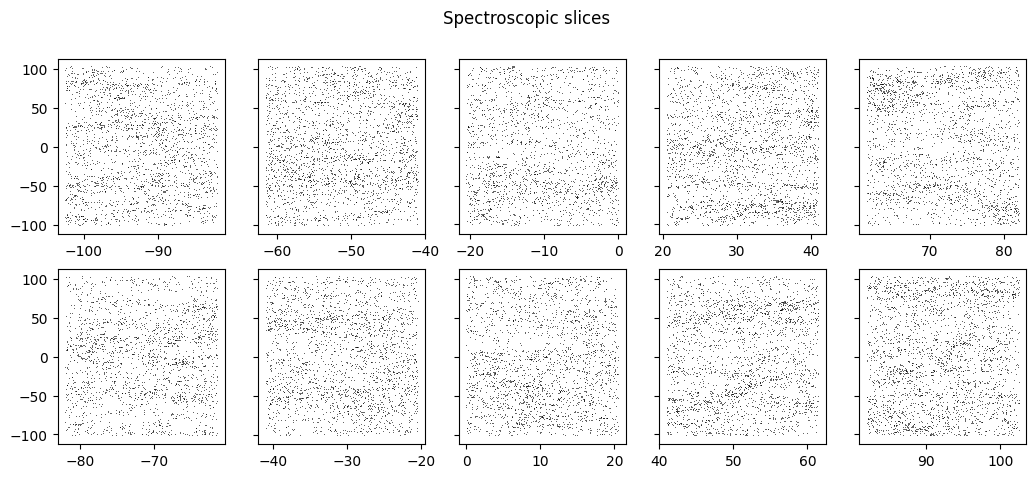

In [17]:
# check out the slices
nrows, ncols = 2, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2.5, nrows * 2.5))
kwargs = dict(ls='None', marker=',', ms=3, alpha=0.6)
for i in range(nslices):
    row = i % nrows
    col = (i - row) // nrows
    axs[row,col].plot(slices_spec[i][:,2].value, slices_spec[i][:,0].value, c='k', **kwargs)
    if col != 0:
        axs[row,col].set_yticklabels([])
fig.suptitle('Spectroscopic slices')

**photometric sample:** SPHEREx-like galaxies from TNG at the target redshift; selected from spectroscopic sample with a Gaussian centered at the box center

In [18]:
# dx = the standard deviation of the distance spread along the LOS
dx = get_dx(redshift, sigma_z)
dx

<Quantity 34.14988849 Mpc / littleh>

In [19]:
# select galaxies from the spectroscopic sample with a Gaussian PDF
gal_pos_phot = []
for i, pos in enumerate(gal_pos_spec):
    draw = eval_Gaussian(pos[2], dx) * dx.unit
    if draw > np.random.uniform():
        gal_pos_phot.append(pos)
    else:
        continue
gal_pos_phot = np.array(gal_pos_phot) * dx.unit

In [20]:
x, y, z = gal_pos_phot.T.value

In [21]:
# try compressing LOS coords into a slicewidth
gal_pos_phot_comp = np.copy(gal_pos_phot)
gal_pos_phot_comp[:,2] *= slicewidth / L

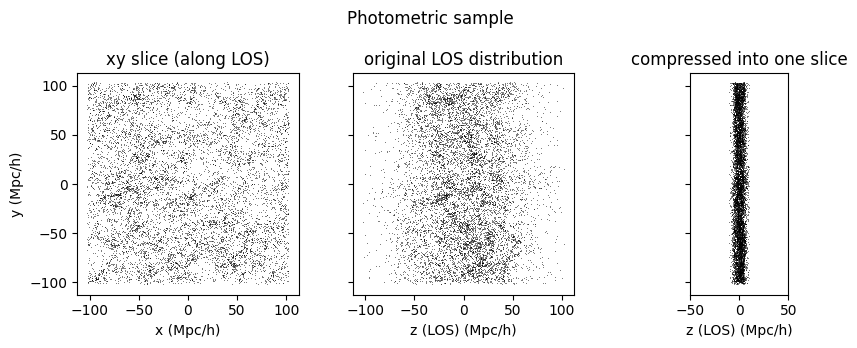

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(9,3.5))
kwargs = dict(c='k', marker=',', ls='None', alpha=0.5)
axs[0].plot(x, y, **kwargs)
axs[0].set_xlabel('x (Mpc/h)')
axs[0].set_ylabel('y (Mpc/h)')
axs[0].set_title('xy slice (along LOS)')
axs[1].plot(z, y, **kwargs)
axs[1].set_xlabel('z (LOS) (Mpc/h)')
axs[1].set_title('original LOS distribution')
axs[2].plot(gal_pos_phot_comp[:,2], gal_pos_phot_comp[:,1], **kwargs)
axs[2].set_xlabel('z (LOS) (Mpc/h)')
axs[2].set_title('compressed into one slice')
axs[2].set_xlim(-50,50)
for i, ax in enumerate(axs):
    ax.set_aspect('equal')
    if i > 0:
        ax.set_yticklabels([])
fig.suptitle('Photometric sample')
fig.tight_layout()

### $\xi(r)$: autocorrelations on full spectroscopic sample

We want to compare
- `Corrfunc.theory.xi`, which uses natural estimator and computes RR term analytically
- "my result" $\equiv$ computing pair counts using `Corrfunc.theory.DD` and then $\xi(r)$ "by hand" via the natural estimator formula

In [23]:
# params
nthreads = 12
rmin = 1.
rmax = 75.
nbins = 20
rbins = np.logspace(np.log10(rmin), np.log10(rmax), nbins+1)

In [24]:
# prep data
X, Y, Z = gal_pos_spec.T.value.astype('float32') + L/2

In [25]:
# direct from Corrfunc (analytic randoms), using the natural estimator
results = xi(L, nthreads, rbins, X, Y, Z, output_ravg=True)
# my natural estimator function, getting the pair counts from Corrfunc
randset = np.random.uniform(0, L, (3*len(X),3))
myresults = compute_xi_autocorr_natural(np.array([X,Y,Z]).T, randset, rbins, L)

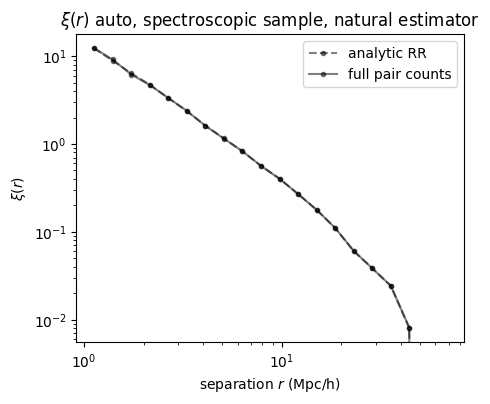

In [24]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(results['ravg'], results['xi'], 'k.--', alpha=0.5, label='analytic RR')
ax.plot(results['ravg'], myresults, 'k.-', alpha=0.5, label='full pair counts')
ax.loglog()
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(r'$\xi(r)$ auto, spectroscopic sample, natural estimator')
ax.legend()

### $w_p(r_p)$: projected autocorrelation on spectroscopic sample

Same test as above, but now with the projected correlation function: `Corrfunc.theory.wp`, `Corrfunc.theory.DDrppi` $\rightarrow\ w_p(r_p)$

In [25]:
# params
pimax = slicewidth  # only count galaxies where Z (LOS) coord <= slicewidth
nthreads = 12
rpmin = 1.
rpmax = 75.
nrpbins = 20
rpbins = np.logspace(np.log10(rpmin), np.log10(rpmax), nbins+1)

In [26]:
# prep data
X, Y, Z = gal_pos_spec.T.value.astype('float32') + L/2

In [27]:
# direct from Corrfunc (analytic randoms), using the natural estimator
results = wp(L, pimax, nthreads, rpbins, X, Y, Z, output_rpavg=True)
# my natural estimator function, getting the pair counts from Corrfunc
randset = np.random.uniform(0, L, (3*len(X),3))
myresults, _, _, _, _ = compute_wp_autocorr_natural(np.array([X,Y,Z]).T, randset, rpbins, L, pimax=pimax)

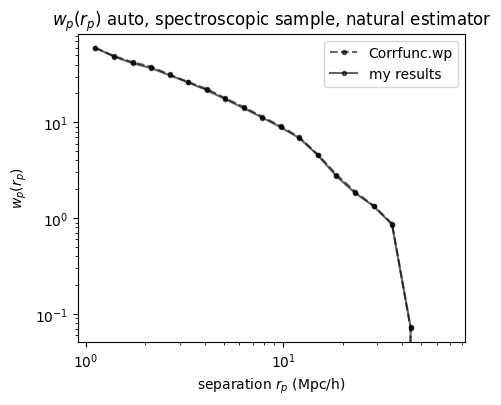

In [28]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(results['rpavg'], results['wp'], 'k.--', alpha=0.6, label='Corrfunc.wp')
ax.plot(results['rpavg'], myresults, 'k.-', alpha=0.6, label='my results')
ax.loglog()
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$')
ax.set_title(r'$w_p(r_p)$ auto, spectroscopic sample, natural estimator')
ax.legend()

### $w_p(r_p)$: projected autocorrelation on spectroscopic slice

Everything matches when we compute the correlation function on the full (i.e. cubic) box (caveat of $\pi_\mathrm{max}$), but we're interested in data where the LOS-dimension is thinner, slices of the box.
In this case:
- What is the result of `Corrfunc.theory.wp` ? Is it correct (i.e. is it only meant to be used on cubic data)?
- For "my result," do I construct the random on the full box, or only in the same dimensions as the slice?

In [38]:
# keep the same parameters as above
# prep data
X, Y, Z = slices_spec[0].T.value.astype('float32') + L/2
# random sets
rx = 4
# just in the slice
randset_slice = np.array([
    np.random.uniform(0, L, rx*len(X)),
    np.random.uniform(0, L, rx*len(X)),
    np.random.uniform(0, slicewidth, rx*len(X))
]).T
# for the whole box
randset_box = np.random.uniform(0, L, (rx*len(X),3))

In [39]:
min(X), min(Y), min(Z), max(Z), slicewidth

(0.4834442, 0.07712555, 0.0026016235, 20.497375, 20.5)

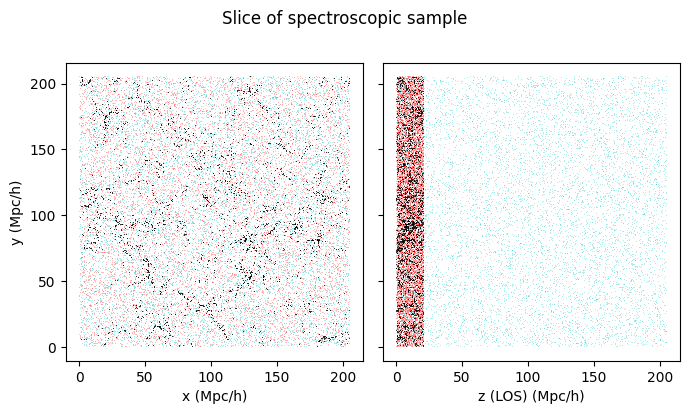

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(7,4))
kwargs = dict(marker=',', alpha=0.3, ls='None')
axs[0].plot(randset_slice[:,0], randset_slice[:,1], c='r', **kwargs)
axs[0].plot(randset_box[:,0], randset_box[:,1], c='c', **kwargs)
axs[0].plot(X, Y, c='k', marker=',', alpha=0.8, ls='None')
axs[0].set_xlabel('x (Mpc/h)')
axs[0].set_ylabel('y (Mpc/h)')
axs[1].plot(randset_slice[:,2], randset_slice[:,1], c='r', **kwargs)
axs[1].plot(randset_box[:,2], randset_box[:,1], c='c', **kwargs)
axs[1].plot(Z, Y, c='k', marker=',', alpha=0.8, ls='None')
axs[1].set_xlabel('z (LOS) (Mpc/h)')
axs[1].set_yticklabels([])
for ax in axs:
    ax.set_aspect('equal')
fig.suptitle('Slice of spectroscopic sample')
fig.tight_layout()

In [41]:
# direct from Corrfunc (analytic randoms), using the natural estimator
results = wp(L, pimax, nthreads, rpbins, X, Y, Z, output_rpavg=True)
# my natural estimator function, getting the pair counts from Corrfunc
myresults_slice, _, _, _, _ = compute_wp_autocorr_natural(np.array([X,Y,Z]).T, randset_slice, rpbins, L, pimax=pimax)
myresults_box, _, _, _, _ = compute_wp_autocorr_natural(np.array([X,Y,Z]).T, randset_box, rpbins, L, pimax=pimax)

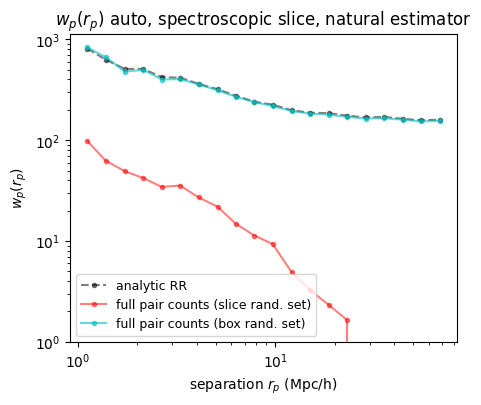

In [42]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(results['rpavg'], results['wp'], 'k.--', alpha=0.5, label='analytic RR')
ax.plot(results['rpavg'], myresults_slice, 'r.-', alpha=0.5, label='full pair counts (slice rand. set)')
ax.plot(results['rpavg'], myresults_box, 'c.-', alpha=0.6, label='full pair counts (box rand. set)')
ax.loglog()
ax.set_ylim(1,None)
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$')
ax.set_title(r'$w_p(r_p)$ auto, spectroscopic slice, natural estimator')
ax.legend(loc=3, prop={'size':9})

$\Rightarrow$ I think the slice random set is the correct one!!

### $\xi(r)$ on the slice: comparing random construction

In [37]:
# direct from Corrfunc (analytic randoms), using the natural estimator
results = xi(L, nthreads, rbins, X, Y, Z, output_ravg=True)
# my natural estimator function, getting the pair counts from Corrfunc
myresults_slice = compute_xi_autocorr_natural(np.array([X,Y,Z]).T, randset_slice, rbins, L)
myresults_box = compute_xi_autocorr_natural(np.array([X,Y,Z]).T, randset_box, rbins, L)

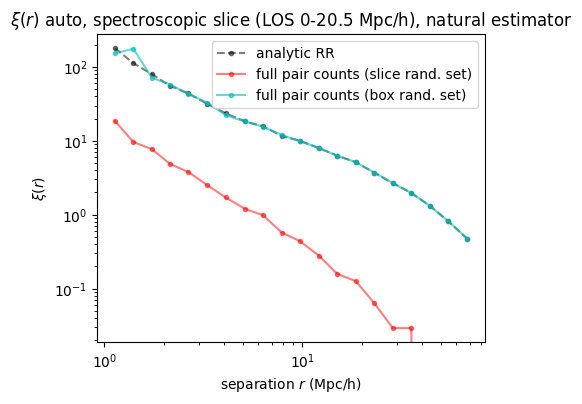

In [38]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(results['ravg'], results['xi'], 'k.--', alpha=0.5, label='analytic RR')
ax.plot(results['ravg'], myresults_slice, 'r.-', alpha=0.5, label='full pair counts (slice rand. set)')
ax.plot(results['ravg'], myresults_box, 'c.-', alpha=0.6, label='full pair counts (box rand. set)')
ax.loglog()
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(r'$\xi(r)$ auto, spectroscopic slice (LOS 0-20.5 Mpc/h), natural estimator')
ax.legend()

#### understanding the role of LOS positions in the projected c.f...

As an intermediate step in computing the 1-dimensional projected correlation function, we/Corrfunc compute/s the 2-dimensional projected correlation function $\xi(r_p,r_\pi)$, where $r_p$ is the separation perpendicular to LOS and $r_\pi$ is the separation parallel to LOS.
Then to get the 1-dim. projected correlation function we need to integrate over $r_\pi$,

$$
w_p(r_p) = \int_{-\infty}^\infty \xi(r_p,r_\pi)\,\mathrm{d}r_\pi
$$

In [43]:
# keep the same parameters as above
# prep data
X, Y, Z = slices_spec[0].T.value.astype('float32') + L/2
# random sets
rx = 4
# just in the slice
randset_slice = np.array([
    np.random.uniform(0, L, rx*len(X)),
    np.random.uniform(0, L, rx*len(X)),
    np.random.uniform(0, slicewidth, rx*len(X))
]).T

In [44]:
res_slice, xirppi_slice, dd, rr, dd_res = compute_wp_autocorr_natural(np.array([X,Y,Z]).T,
                                                                randset_slice, rbins, L, pimax=pimax)

In [45]:
pibins = dd_res['pimax'][:len(xirppi_slice)//nbins]
pibins

array([ 1.025,  2.05 ,  3.075,  4.1  ,  5.125,  6.15 ,  7.175,  8.2  ,
        9.225, 10.25 , 11.275, 12.3  , 13.325, 14.35 , 15.375, 16.4  ,
       17.425, 18.45 , 19.475, 20.5  ])

In [46]:
# xirppi is an unrolled 2D array - roll it back up to visualize
xirppi_slice_2D = np.array(np.array_split(xirppi_slice, nbins))

Text(0.5, 1.0, '$\\xi(r_p,r_\\pi)$, spectroscopic slice')

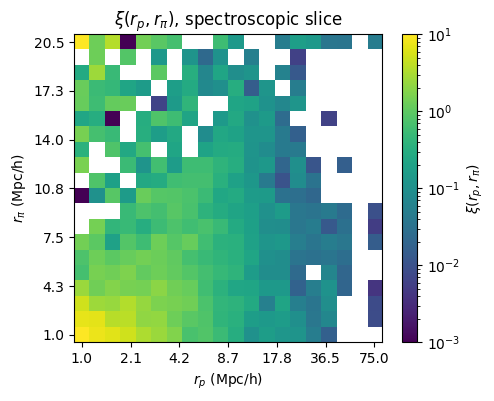

In [47]:
# norm = mpl.colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=8)

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(xirppi_slice_2D.T, origin='lower', norm='log', vmin=1e-3, vmax=10) #, cmap='coolwarm', norm=norm)
xlabels = [f'{x:.1f}' for x in np.logspace(np.log10(rpmin), np.log10(rpmax), 7)]
ax.set_xticks(np.linspace(0,19,7), labels=xlabels)
ax.set_xlabel('$r_p$ (Mpc/h)')
ylabels = [f'{x:.1f}' for x in np.linspace(min(pibins), max(pibins), 7)]
ax.set_yticks(np.linspace(0,19,7), labels=ylabels)
ax.set_ylabel(r'$r_\pi$ (Mpc/h)')
fig.colorbar(im, ax=ax, label=r'$\xi(r_p,r_\pi)$')
ax.set_title(r'$\xi(r_p,r_\pi)$, spectroscopic slice')

ValueError: no field of name ravg

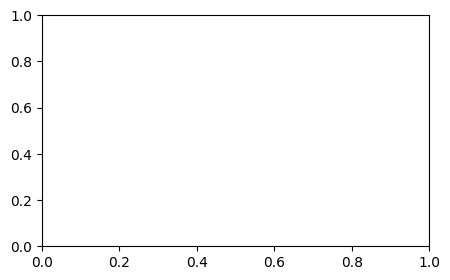

In [48]:
# now we sum along pi
wptest = 2. * np.sum(xirppi_slice_2D, axis=1)

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(results['ravg'], res_slice, 'k.-', alpha=0.5) # compare to function result
ax.plot(results['ravg'], wptest, 'k.--', alpha=0.5)
ax.loglog()
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$')

#### try setting all LOS coordinates to zero

In [49]:
Zzero = np.zeros_like(X)
randset_zero = np.array([
    np.random.uniform(0, L, rx*len(X)),
    np.random.uniform(0, L, rx*len(X)),
    np.zeros(rx*len(X))
]).T

In [50]:
res_zero, xirppi_zero, dd, rr, dd_res = compute_wp_autocorr_natural(np.array([X,Y,Zzero]).T,
                                                                randset_zero, rbins, L, pimax=1.)

         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.

In [51]:
# xirppi is an unrolled 2D array - roll it back up to visualize
xirppi_zero_2D = np.array(np.array_split(xirppi_zero, nbins))

Text(0.5, 1.0, '$\\xi(r_p,r_\\pi)$, spectroscopic slice (z (LOS) = 0, pimax=1)')

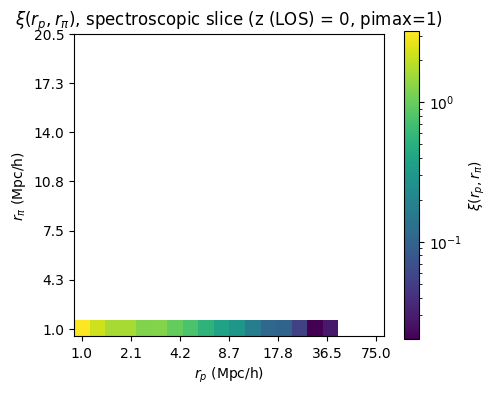

In [52]:
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(xirppi_zero_2D.T, origin='lower', norm='log')
xlabels = [f'{x:.1f}' for x in np.logspace(np.log10(rpmin), np.log10(rpmax), 7)]
ax.set_xticks(np.linspace(0,19,7), labels=xlabels)
ax.set_xlabel('$r_p$ (Mpc/h)')
ylabels = [f'{x:.1f}' for x in np.linspace(min(pibins), max(pibins), 7)]
ax.set_yticks(np.linspace(0,19,7), labels=ylabels)
ax.set_ylabel(r'$r_\pi$ (Mpc/h)')
fig.colorbar(im, ax=ax, label=r'$\xi(r_p,r_\pi)$')
ax.set_title(r'$\xi(r_p,r_\pi)$, spectroscopic slice (z (LOS) = 0, pimax=1)')

Text(0, 0.5, '$w_p(r_p)$')

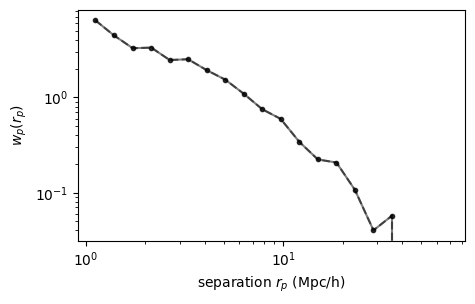

In [54]:
# now we sum along pi
wptest = 2. * np.sum(xirppi_zero_2D, axis=1)

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(results['rpavg'], res_zero, 'k.-', alpha=0.5) # compare to function result
ax.plot(results['rpavg'], wptest, 'k.--', alpha=0.5)
ax.loglog()
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$')

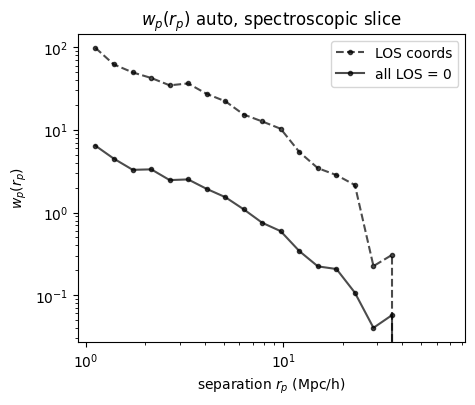

In [57]:
# compare the two LOS coordinate cases (original slice z-coords and setting all z=0)
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(results['rpavg'], res_slice, 'k.--', alpha=0.7, label='LOS coords')
ax.plot(results['rpavg'], res_zero, 'k.-', alpha=0.7, label='all LOS = 0')
ax.loglog()
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$')
ax.set_title(r'$w_p(r_p)$ auto, spectroscopic slice')
ax.legend()

$\Rightarrow$ It looks like the two LOS coordinate cases are actually consistent, except for some normalization factor... ($\sim$`slicewidth`)

### cross 2D photometric sample and spectroscopic slice

In [97]:
# keep same params

In [113]:
# prep data
phot_sample = gal_pos_phot.value.astype('float32') + L/2
phot_sample[:,2] = np.zeros_like(phot_sample[:,0])
spec_sample = slices_spec[0].value.astype('float32') + L/2
spec_sample[:,2] = np.zeros_like(spec_sample[:,0])
rx = 2
randset_zero = np.array([
    np.random.uniform(0, L, rx*len(spec_sample)),
    np.random.uniform(0, L, rx*len(spec_sample)),
    np.zeros(rx*len(spec_sample))
]).T

In [114]:
phot_sample.shape, spec_sample.shape, randset_zero.shape

((9926, 3), (2354, 3), (4708, 3))

In [127]:
wp_cross, xirppi, d1d2, d1r2, d1d2_res = compute_wp_xcorr_natural(phot_sample, spec_sample, randset_zero, rpbins, L, pimax=1.)

         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.

Text(0, 0.5, '$w_p(r_p)$')

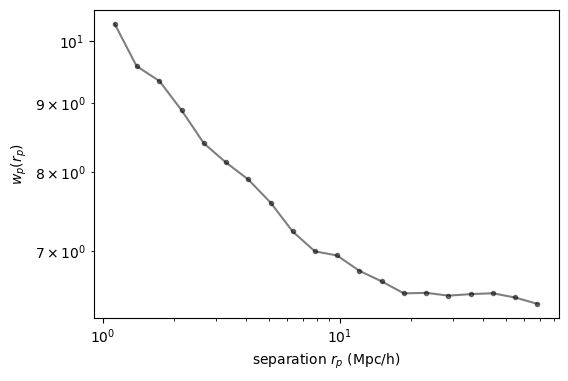

In [128]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(results['rpavg'], wp_cross, 'k.-', alpha=0.5)
ax.loglog()
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$')

### cross-correlate slices of spectroscopic sample with photometric sample

In [34]:
# random sets: 3D cubic volume to start
randset_phot = np.random.uniform(-L/2, L/2, (len(gal_pos_phot),3))
randset_spec = np.random.uniform(-L/2, L/2, (len(gal_pos_spec),3))

# data sets: remove units and shift spectroscopic sample LOS coords to center at zero
phot_sample = gal_pos_phot.value  # already centered at zero
islice = 0
spec_sample = np.copy(slices_spec[islice]).value
spec_sample[:,2] -= slice_centers[islice]  # take one slice and shift z to center at zero

Text(0.5, 1.0, 'Samples for correlation functions')

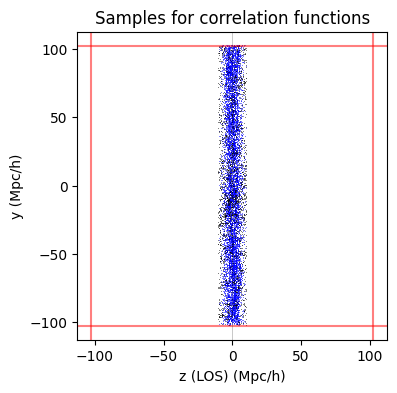

In [35]:
# check that everything is centered at zero
fig, ax = plt.subplots(figsize=(4,4))
kwargs = dict(marker=',', ls='None', alpha=0.5)
ax.plot(phot_sample[:,2], phot_sample[:,1], c='b', **kwargs)
ax.plot(spec_sample[:,2], spec_sample[:,1], c='k', **kwargs)
# ax.plot(randset_spec[:,2], randset_spec[:,1], c='r', **kwargs)
ax.axvline(min(randset_spec[:,2]), c='r', alpha=0.5)
ax.axvline(max(randset_spec[:,2]), c='r', alpha=0.5)
ax.axhline(min(randset_spec[:,1]), c='r', alpha=0.5)
ax.axhline(max(randset_spec[:,1]), c='r', alpha=0.5)
ax.axvline(0, lw=0.5, c='k', alpha=0.3)
ax.set_xlabel('z (LOS) (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_title('Samples for correlation functions')

In [44]:
# set all z to zero
for i, sample in enumerate([phot_sample, spec_sample, randset_phot, randset_spec]):
    sample[:,2] = 0

In [ ]:
# compress each sample along LOS to fit into thin slice at box center
D = 20  # width of the final slice
for i, sample in enumerate([phot_sample, spec_sample, randset_phot, randset_spec]):
    sample[:,2] *= D/L

In [ ]:
# shift to all positive values
slicewidth = 

In [29]:
# autocorrs for each sample
res_phot = wp(L, pimax, nthreads, rpbins, *phot_sample.T, output_rpavg=True)
res_spec = wp(L, pimax, nthreads, rpbins, *spec_sample.T, output_rpavg=True)
res_randphot = wp(L, pimax, nthreads, rpbins, *randset_phot.T, output_rpavg=True)
res_randspec = wp(L, pimax, nthreads, rpbins, *randset_spec.T, output_rpavg=True)

Error in file: ../../utils/gridlink_impl_float.c	func: gridlink_float	line: 187 with expression `out_of_bounds == 0'
5574 particles are out of bounds. Check periodic wrapping?
Hopefully, input validation. Otherwise, bug in code: please file an issue on GitHub: https://github.com/manodeep/Corrfunc/issues


RuntimeError: RuntimeError occurred

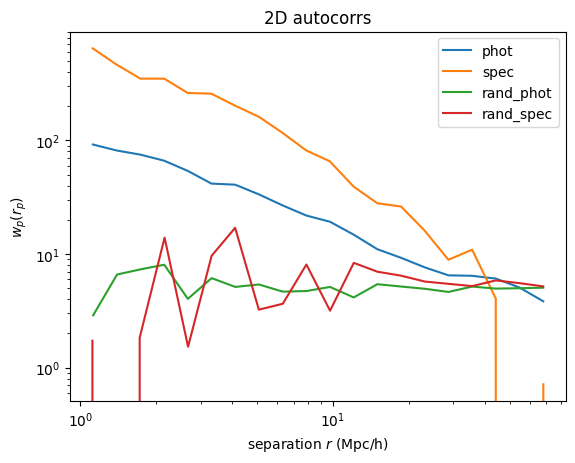

In [78]:
fig, ax = plt.subplots()
labels = ['phot', 'spec', 'rand_phot', 'rand_spec']
for i, res in enumerate([res_phot, res_spec, res_randphot, res_randspec]):
    ax.plot(res['rpavg'], res['wp'], label=labels[i])
ax.loglog()
ax.set_xlabel('separation $r$ (Mpc/h)')
ax.set_ylabel('$w_p(r_p)$')
ax.set_title('2D autocorrs')
ax.legend()

In [83]:
res = compute_2D_xcorr_LS(phot_sample, spec_sample, randset_phot, randset_spec, rpbins, L, dtype=float)

         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.
         Corrfunc will operate correctly, but make sure this is what you expected.Warning: all particles appear to have the same Z coordinate.

In [84]:
res

array([          nan,           nan,           nan,           nan,
                 nan,           nan, -280.52631579, -351.04081633,
       -133.6109589 , -129.58319328, -153.52572146, -466.37923251,
       -206.10847458, -175.90708302, -157.3545781 , -193.27554395,
       -151.34917299, -170.14773025, -154.24637906, -147.56479969])

In [ ]:
wps = np.empty((nslices, nbins))
# for i in range(nslices):
i = 0